In [1]:
try: #If running in colab 
    import google.colab
    !pip install --upgrade --no-cache-dir catboost 
    !pip install pytorch_tabnet
    !pip install torch
    !pip install --upgrade --no-cache-dir seaborn
    !pip install --upgrade --no-cache-dir featuretools
    !pip install --upgrade --no-cache-dir xgboost
    !pip install --upgrade --no-cache-dir tqdm
    !pip install --upgrade --no-cache-dir psutil
    !pip install --upgrade --no-cache-dir openpyxl
    !pip install --upgrade --no-cache-dir category_encoders
    !pip install --upgrade --no-cache-dir setuptools pandas numpy scipy scikit-learn
    !pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

    from google.colab import drive
    drive.mount('/content/drive')

    %cd /content
    %mkdir submissions
    %mkdir storage
    
    IN_COLAB = True
except:
    IN_COLAB = False

     |████████████████████████████████| 65.8MB 1.3MB/s 
Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.11.1)
     |████████████████████████████████| 296kB 16.3MB/s 
     |████████████████████████████████| 675kB 44.8MB/s 
     |████████████████████████████████| 102kB 58.1MB/s 
     |████████████████████████████████| 102kB 62.8MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7667 sha256=9e4d458d00870040dc8043d105ef92e97f3caa06c5c8207a53f0548541ec3809
  Stored in directory: /tmp/pip-ephem-wheel-cache-f1ksbs_q/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built contextvars
ERROR: distributed 2021.2.0 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
ERROR: distributed 2021.2.0 has requirement dask>=2021.02.0, but you'll have dask 2.12.0 which is incompatible.
  Found existing installation: distributed 1.25.3
    Uninstalling distributed-1.

# New Section

In [2]:
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder,FunctionTransformer
from category_encoders import OrdinalEncoder
import psutil
from sklearn.model_selection import KFold
import catboost as cgb
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import seaborn as sns


from pytorch_tabnet.tab_model import TabNetClassifier
import torch

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import pandas as pd
train_data='/content/drive/MyDrive/Colab Notebooks/Train/'
test_path='/content/drive/MyDrive/Colab Notebooks/Test/'
train_data=pd.read_excel(train_data+'train_Data.xlsx')


In [4]:
test_bur=pd.read_excel(test_path+'test_bureau.xlsx')
test_data=pd.read_excel(test_path+'test_Data.xlsx')

In [5]:
train_bur=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Train/train_bureau.xlsx')

# New Section

In [46]:
train_all=pd.merge(train_data,train_bur,on="ID")

In [47]:
train_bur.shape

(560844, 25)

In [48]:
train_all.shape

(560844, 50)

In [49]:
train_all['Top-up Month'].value_counts()

No Top-up Service    385604
 > 48 Months          80114
36-48 Months          26613
24-30 Months          22511
30-36 Months          19044
18-24 Months          17766
12-18 Months           9192
Name: Top-up Month, dtype: int64

In [50]:
test_all=pd.merge(test_data,test_bur,on='ID')

In [51]:
test_all.shape

(64019, 49)

In [52]:
print("columns not in test  data" ,[col for col in train_all if col not in test_all])

columns not in test  data ['Top-up Month']


In [53]:
test_all['Top-up Month']=np.nan

In [54]:
train_all['source']='Train'
test_all['source']='test'

In [55]:
df_all=pd.concat([train_all,test_all],ignore_index=True)

In [56]:
df_all.shape

(624863, 51)

In [57]:
df_all.dtypes

ID                                    int64
Frequency                            object
InstlmentMode                        object
LoanStatus                           object
PaymentMode                          object
BranchID                              int64
Area                                 object
Tenure                                int64
AssetCost                             int64
AmountFinance                       float64
DisbursalAmount                     float64
EMI                                 float64
DisbursalDate                datetime64[ns]
MaturityDAte                 datetime64[ns]
AuthDate                     datetime64[ns]
AssetID                               int64
ManufacturerID                      float64
SupplierID                            int64
LTV                                 float64
SEX                                  object
AGE                                 float64
MonthlyIncome                       float64
City                            

In [58]:
categorical_feat=['Frequency','InstlmentMode','LoanStatus','PaymentMode','Area','SEX','City','State','SELF-INDICATOR','MATCH-TYPE',
                  'ACCT-TYPE','CONTRIBUTOR-TYPE','OWNERSHIP-IND','ACCOUNT-STATUS',
                  'INSTALLMENT-FREQUENCY','ASSET_CLASS']
date_feat=['DisbursalDate','MaturityDAte','AuthDate','DATE-REPORTED','DISBURSED-DT','CLOSE-DT','LAST-PAYMENT-DATE']
continous_feat=[col for col in df_all.columns if col not in categorical_feat and col not in date_feat ]

#Preprocessing

In [59]:
df_all['DISBURSED-AMT/HIGH CREDIT'] = df_all['DISBURSED-AMT/HIGH CREDIT'].str.replace(',', '').astype(float)
df_all['CURRENT-BAL'] = df_all['CURRENT-BAL'].str.replace(',', '').astype(float)
df_all['OVERDUE-AMT'] = df_all['OVERDUE-AMT'].str.replace(',', '').astype(float)
df_all['INSTALLMENT-AMT']=df_all['INSTALLMENT-AMT'].str.split('/',expand=True)[0].str.replace(',', '').astype(float)
df_all['CREDIT-LIMIT/SANC AMT'] = df_all['CREDIT-LIMIT/SANC AMT'].str.replace(',', '').astype(float)

# Feature Engineering

In [60]:
df_all.head()

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,AuthDate,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up Month,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,CLOSE-DT,LAST-PAYMENT-DATE,CREDIT-LIMIT/SANC AMT,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,REPORTED DATE - HIST,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,TENURE,source
0,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,4022465,1568.0,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0,> 48 Months,False,PRIMARY,Overdraft,NAB,2018-04-30,Individual,Delinquent,2015-10-05,NaN,2018-02-27,NaN,37352.0,NaN,37873.0,NaN,37873.0,0.0,Standard,"20180430,20180331,",030000,"37873,12820,","37873,,",",,",NaN,Train
1,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,4022465,1568.0,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0,> 48 Months,False,PRIMARY,Auto Loan (Personal),NAB,2019-12-31,Individual,Active,2018-03-19,NaN,2019-12-19,NaN,44000.0,1405.0,20797.0,F03,NaN,0.0,Standard,"20191231,20191130,20191031,20190930,20190831,2...",0000000000000000000000000000000000000000000000...,"20797,21988,23174,24341,25504,26648,27780,2891...",",,,,,,,,,,,,,,,,,,,,1452,,",",,,,,,,,,,,,,,,,,,,,,,",36.0,Train
2,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,4022465,1568.0,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0,> 48 Months,True,PRIMARY,Tractor Loan,NBF,2020-01-31,Individual,Active,2019-08-30,NaN,NaT,NaN,145000.0,NaN,116087.0,NaN,0.0,0.0,NaN,"20200131,20191231,20191130,20191031,20190930,2...",000000000000000000,"116087,116087,145000,145000,145000,145000,","0,0,0,0,0,0,",",,,,,,",NaN,Train
3,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,4022465,1568.0,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0,> 48 Months,True,PRIMARY,Auto Loan (Personal),NBF,2017-09-30,Individual,Closed,2013-09-27,2017-09-21 00:00:00,NaT,NaN,300000.0,NaN,0.0,NaN,0.0,0.0,NaN,"20170930,20170801,20170731,20170630,20170531,2...",000DDD0270260270260270240270270000320000000000...,"0,,15925,23754,31494,39147,46713,54194,61590,6...","0,,1014,1014,1014,1014,1014,1014,1014,983,0,92...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN,Train
4,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,4022465,1568.0,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0,> 48 Months,True,PRIMARY,Tractor Loan,NBF,2016-02-29,Individual,Closed,2012-02-10,2016-02-01 00:00:00,NaT,NaN,275000.0,NaN,0.0,NaN,0.0,0.0,NaN,"20160229,20160131,20151231,20151130,20151031,2...",0000000000000000000000000000000000000000000000...,"0,0,23658,23321,22989,46321,45662,45012,68030,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN,Train


In [61]:
#df_all['age_range']=pd.cut(df_all['AGE'],bins=[1,19,30,50,100])

Text(0, 0.5, 'Frequency')

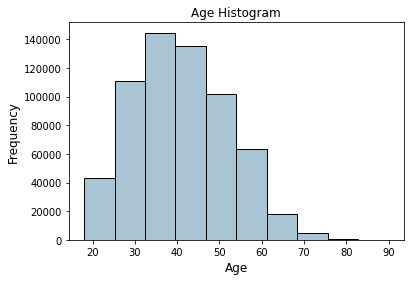

In [62]:
fig, ax = plt.subplots()
df_all['AGE'].hist(color='#A9C5D3', edgecolor='black',  
                          grid=False)
ax.set_title('Age Histogram', fontsize=12)
ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [63]:
# bin_ranges = [0, 15, 30, 45, 60, 75, 100]
# bin_names = [1, 2, 3, 4, 5, 6]
# df_all['Age_bin_custom_range'] = pd.cut(
#                                            np.array(
#                                               df_all['AGE']), 
#                                               bins=bin_ranges)
# df_all['Age_bin_custom_label'] = pd.cut(
#                                            np.array(
#                                               df_all['AGE']), 
#                                               bins=bin_ranges,            
#                                               labels=bin_names)


In [64]:
df_all["RANK"] = df_all.groupby("ID")['ID'].rank(method="first", ascending=True)
df_all["RANK_avg"] = df_all.groupby("ID")['ID'].rank(method="average", ascending=True)
df_all["RANK_max"] = df_all.groupby("ID")['ID'].rank(method="max", ascending=True)
df_all["RANK_min"] = df_all.groupby("ID")['ID'].rank(method="min", ascending=True)
df_all["RANK_DIFF"] = df_all['RANK_max'] - df_all['RANK_min']

In [66]:
df_all['no_of_months_of_loan']=(df_all['MaturityDAte']-df_all['DisbursalDate']).fillna(pd.Timedelta(seconds=1))

In [67]:
df_all['no_of_month_loan_left']=(df_all['LAST-PAYMENT-DATE']-df_all['MaturityDAte']).fillna(pd.Timedelta(seconds=1))

In [68]:
df_all['Time_loan_paid']=(df_all['LAST-PAYMENT-DATE']-df_all['DisbursalDate']).fillna(pd.Timedelta(seconds=1))

In [70]:
for col1, col2 in [
                   ["AssetCost", "DisbursalAmount"],
                   ["AmountFinance", "CURRENT-BAL"],
                   ["DISBURSED-AMT/HIGH CREDIT","CREDIT-LIMIT/SANC AMT"]
                  ]:
    df_all[col1 + "_diff_" + col2] = df_all[col1].astype('float') - df_all[col2].astype('float')

In [71]:
for col1, col2 in [["CURRENT-BAL", "DisbursalAmount"],
                   ["DisbursalAmount", "AmountFinance"],
                   ["DISBURSED-AMT/HIGH CREDIT","CREDIT-LIMIT/SANC AMT"]
                  ]:
    df_all[col1+"_ratio_"+col2] = df_all[col1] / df_all[col2]

In [72]:
df_all['Tenure_income']=df_all['MonthlyIncome']*df_all['Tenure']

In [73]:
for col in ["ZiPCODE", "ManufacturerID", "SupplierID",
           ]:
    if not isinstance(col, list):
        col = [col]
    col_name = "_".join(col)
    gdf = df_all.groupby(col)["LTV"].agg(["mean", "std", "max"]).reset_index()
    gdf.columns = col + [col_name+"_ltv_mean", col_name+"_ltv_std", col_name+"_ltv_max"]
    df_all = pd.merge(df_all, gdf, on=col, how="left")

In [74]:
x=df_all['CUR BAL - HIST'].str.split(",",expand=True).fillna(0).replace(r'^\s*$', 0, regex=True)
df_all['mean_cur_bal']=x.mean(axis=1,skipna=True)

In [75]:
df_all['std_cur_bal']=x.std(axis=1,skipna=True)

In [76]:
x=df_all['AMT OVERDUE - HIST'].str.split(",",expand=True).fillna(0).replace(r'^\s*$', 0, regex=True)
df_all['mean_overdue']=x.mean(axis=1,skipna=True)
df_all['std_overdue']=x.std(axis=1,skipna=True)

In [77]:
x=df_all['AMT PAID - HIST'].str.split(",",expand=True).fillna(0).replace(r'^\s*$', 0, regex=True)
df_all['mean_paid']=x.mean(axis=1,skipna=True)
df_all['std_paid']=x.std(axis=1,skipna=True)

In [78]:
  df_all.head()

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,AuthDate,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up Month,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,CLOSE-DT,LAST-PAYMENT-DATE,CREDIT-LIMIT/SANC AMT,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,...,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,REPORTED DATE - HIST,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,TENURE,source,RANK,RANK_avg,RANK_max,RANK_min,RANK_DIFF,no_of_months_of_loan,no_of_month_loan_left,Time_loan_paid,AssetCost_diff_DisbursalAmount,AmountFinance_diff_CURRENT-BAL,DISBURSED-AMT/HIGH CREDIT_diff_CREDIT-LIMIT/SANC AMT,CURRENT-BAL_ratio_DisbursalAmount,DisbursalAmount_ratio_AmountFinance,DISBURSED-AMT/HIGH CREDIT_ratio_CREDIT-LIMIT/SANC AMT,Tenure_income,ZiPCODE_ltv_mean,ZiPCODE_ltv_std,ZiPCODE_ltv_max,ManufacturerID_ltv_mean,ManufacturerID_ltv_std,ManufacturerID_ltv_max,SupplierID_ltv_mean,SupplierID_ltv_std,SupplierID_ltv_max,mean_cur_bal,std_cur_bal,mean_overdue,std_overdue,mean_paid,std_paid
0,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,4022465,1568.0,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0,> 48 Months,False,PRIMARY,Overdraft,NAB,2018-04-30,Individual,Delinquent,2015-10-05,NaN,2018-02-27,NaN,37352.0,NaN,37873.0,...,37873.0,0.0,Standard,"20180430,20180331,",030000,"37873,12820,","37873,,",",,",NaN,Train,1.0,5.0,9.0,1.0,8.0,1435 days,774 days 00:00:00,2209 days 00:00:00,175000.0,237127.0,NaN,0.137720,1.0,NaN,1719999.84,62.750179,16.692085,89.34,61.862418,14.955145,98.7,68.817376,10.494206,86.33,0.0,NaN,NaN,NaN,0.0,NaN
1,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,4022465,1568.0,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0,> 48 Months,False,PRIMARY,Auto Loan (Personal),NAB,2019-12-31,Individual,Active,2018-03-19,NaN,2019-12-19,NaN,44000.0,1405.0,20797.0,...,NaN,0.0,Standard,"20191231,20191130,20191031,20190930,20190831,2...",0000000000000000000000000000000000000000000000...,"20797,21988,23174,24341,25504,26648,27780,2891...",",,,,,,,,,,,,,,,,,,,,1452,,",",,,,,,,,,,,,,,,,,,,,,,",36.0,Train,2.0,5.0,9.0,1.0,8.0,1435 days,1434 days 00:00:00,2869 days 00:00:00,175000.0,254203.0,NaN,0.075625,1.0,NaN,1719999.84,62.750179,16.692085,89.34,61.862418,14.955145,98.7,68.817376,10.494206,86.33,0.0,NaN,NaN,NaN,0.0,NaN
2,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,4022465,1568.0,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0,> 48 Months,True,PRIMARY,Tractor Loan,NBF,2020-01-31,Individual,Active,2019-08-30,NaN,NaT,NaN,145000.0,NaN,116087.0,...,0.0,0.0,NaN,"20200131,20191231,20191130,20191031,20190930,2...",000000000000000000,"116087,116087,145000,145000,145000,145000,","0,0,0,0,0,0,",",,,,,,",NaN,Train,3.0,5.0,9.0,1.0,8.0,1435 days,0 days 00:00:01,0 days 00:00:01,175000.0,158913.0,NaN,0.422135,1.0,NaN,1719999.84,62.750179,16.692085,89.34,61.862418,14.955145,98.7,68.817376,10.494206,86.33,0.0,NaN,NaN,NaN,0.0,NaN
3,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,4022465,1568.0,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0,> 48 Months,True,PRIMARY,Auto Loan (Personal),NBF,2017-09-30,Individual,Closed,2013-09-27,2017-09-21 00:00:00,NaT,NaN,300000.0,NaN,0.0,...,0.0,0.0,NaN,"20170930,20170801,20170731,20170630,20170531,2...",000DDD0270260270260270240270270000320000000000...,"0,,15925,23754,31494,39147,46713,54194,61590,6...","0,,1014,1014,1014,1014,1014,1014,1014,983,0,92...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN,Train,4.0,5.0,9.0,1.0,8.0,1435 days,0 days 00:00:01,0 days 00:00:01,175000.0,275000.0,NaN,0.000000,1.0,NaN,1719999.84,62.750179,16.692085,89.34,61.862418,14.9551

In [79]:
def get_agg_features(df, feature_tuple):
    print("getting aggregated features...")
    feature_dict = {}
    for comb in tqdm(feature_tuple, ncols = 5):
        op = comb[2].__name__ if hasattr(comb[2], '__call__') else str(comb[2])
        feature_name = f"{op}_{comb[1]}_by_{'__'.join(comb[0])}"
        feature = df.groupby(comb[0])[comb[1]].transform(comb[2])
        feature_dict[feature_name] = feature.values
    return pd.DataFrame(feature_dict)

In [80]:
agg_features_list = [
            (['ID'], 'BranchID', 'size'),
            (['ID'], 'AssetCost', 'mean'),
            (['ID'], 'AmountFinance', 'mean'),
            (['ID'], 'EMI', "mean"),
            (['ID'], 'MonthlyIncome', 'mean')]

In [81]:
 print("getting ratio/aggregated features...(this may a minute or two)")
agg_features = get_agg_features(df_all, agg_features_list)
print(f'aggregate features: {agg_features.shape}')
df_all = pd.concat([df_all, agg_features], axis = 1)

100%|

getting ratio/aggregated features...(this may a minute or two)
getting aggregated features...
aggregate features: (624863, 5)


In [82]:
df_all.head()

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,AuthDate,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up Month,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,CLOSE-DT,LAST-PAYMENT-DATE,CREDIT-LIMIT/SANC AMT,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,...,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,TENURE,source,RANK,RANK_avg,RANK_max,RANK_min,RANK_DIFF,no_of_months_of_loan,no_of_month_loan_left,Time_loan_paid,AssetCost_diff_DisbursalAmount,AmountFinance_diff_CURRENT-BAL,DISBURSED-AMT/HIGH CREDIT_diff_CREDIT-LIMIT/SANC AMT,CURRENT-BAL_ratio_DisbursalAmount,DisbursalAmount_ratio_AmountFinance,DISBURSED-AMT/HIGH CREDIT_ratio_CREDIT-LIMIT/SANC AMT,Tenure_income,ZiPCODE_ltv_mean,ZiPCODE_ltv_std,ZiPCODE_ltv_max,ManufacturerID_ltv_mean,ManufacturerID_ltv_std,ManufacturerID_ltv_max,SupplierID_ltv_mean,SupplierID_ltv_std,SupplierID_ltv_max,mean_cur_bal,std_cur_bal,mean_overdue,std_overdue,mean_paid,std_paid,size_BranchID_by_ID,mean_AssetCost_by_ID,mean_AmountFinance_by_ID,mean_EMI_by_ID,mean_MonthlyIncome_by_ID
0,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,4022465,1568.0,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0,> 48 Months,False,PRIMARY,Overdraft,NAB,2018-04-30,Individual,Delinquent,2015-10-05,NaN,2018-02-27,NaN,37352.0,NaN,37873.0,...,"37873,12820,","37873,,",",,",NaN,Train,1.0,5.0,9.0,1.0,8.0,1435 days,774 days 00:00:00,2209 days 00:00:00,175000.0,237127.0,NaN,0.137720,1.0,NaN,1719999.84,62.750179,16.692085,89.34,61.862418,14.955145,98.7,68.817376,10.494206,86.33,0.0,NaN,NaN,NaN,0.0,NaN,9,450000,275000.0,24000.0,35833.33
1,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,4022465,1568.0,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0,> 48 Months,False,PRIMARY,Auto Loan (Personal),NAB,2019-12-31,Individual,Active,2018-03-19,NaN,2019-12-19,NaN,44000.0,1405.0,20797.0,...,"20797,21988,23174,24341,25504,26648,27780,2891...",",,,,,,,,,,,,,,,,,,,,1452,,",",,,,,,,,,,,,,,,,,,,,,,",36.0,Train,2.0,5.0,9.0,1.0,8.0,1435 days,1434 days 00:00:00,2869 days 00:00:00,175000.0,254203.0,NaN,0.075625,1.0,NaN,1719999.84,62.750179,16.692085,89.34,61.862418,14.955145,98.7,68.817376,10.494206,86.33,0.0,NaN,NaN,NaN,0.0,NaN,9,450000,275000.0,24000.0,35833.33
2,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,4022465,1568.0,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0,> 48 Months,True,PRIMARY,Tractor Loan,NBF,2020-01-31,Individual,Active,2019-08-30,NaN,NaT,NaN,145000.0,NaN,116087.0,...,"116087,116087,145000,145000,145000,145000,","0,0,0,0,0,0,",",,,,,,",NaN,Train,3.0,5.0,9.0,1.0,8.0,1435 days,0 days 00:00:01,0 days 00:00:01,175000.0,158913.0,NaN,0.422135,1.0,NaN,1719999.84,62.750179,16.692085,89.34,61.862418,14.955145,98.7,68.817376,10.494206,86.33,0.0,NaN,NaN,NaN,0.0,NaN,9,450000,275000.0,24000.0,35833.33
3,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,4022465,1568.0,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0,> 48 Months,True,PRIMARY,Auto Loan (Personal),NBF,2017-09-30,Individual,Closed,2013-09-27,2017-09-21 00:00:00,NaT,NaN,300000.0,NaN,0.0,...,"0,,15925,23754,31494,39147,46713,54194,61590,6...","0,,1014,1014,1014,1014,1014,1014,1014,983,0,92...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN,Train,4.0,5.0,9.0,1.0,8.0,1435 days,0 days 00:00:01,0 days 00:00:01,175000.0,275000.0,NaN,0.000000,1.0,NaN,1719999.84,62.750179,16.692085,89.34,61.862418,14.955145,98.7,68.817376,10.494206,86.33,0.0,NaN,NaN,NaN,0.0,NaN,9,450000,275000.0,24000.0,35833.33
4,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,4022465,1568.0,21946,61.

Categorical features

In [83]:

print("encoding date and categorical features...")
oe = OrdinalEncoder(return_df=False, handle_missing='return_nan', handle_unknown='error', drop_invariant=False)
df_all[categorical_feat] = oe.fit_transform(df_all[categorical_feat]) - 1
df_all[categorical_feat] = df_all[categorical_feat].fillna(-1)


# for col in source_dt_cols:
#     df[col] = df[col].map(date_to_integer)

encoding date and categorical features...


In [84]:
fucnT = FunctionTransformer(lambda X: X.astype('int'))
df_all[categorical_feat] = fucnT.fit_transform(df_all[categorical_feat])

In [85]:
# oe = OrdinalEncoder()
# for cat_cols in categorical_feat:
#   if cat_cols not in ['Top-up Month','Area','SEX','City','INSTALLMENT-FREQUENCY','ASSET_CLASS']:
#       print(cat_cols)
#       df_all[cat_cols] = df_all[cat_cols].fillna(-1)
#       df_all[[cat_cols]] = oe.fit_transform(df_all[[cat_cols]])
  

Date Time feature

In [86]:
print("performing to_datetime...")
#source_dt_cols = ['DisbursalDate', 'MaturityDAte', 'AuthDate', 'CLOSE-DT', 'DISBURSED-DT', 'DATE-REPORTED', 'LAST-PAYMENT-DATE']
for col in date_feat:
    df_all[col] = pd.to_datetime(df_all[col], errors='coerce')

performing to_datetime...


In [87]:
for date_col in date_feat:
    df_all[date_col] = pd.to_datetime(df_all[date_col], format="%d/%m/%y")
    df_all[date_col] = pd.to_datetime(df_all[date_col], format="%d/%m/%y")
    
    df_all[date_col + "_day"] = df_all[date_col].dt.day.astype(float)
    
    
    df_all[date_col + "_month"] = df_all[date_col].dt.month.astype(float)
    
    
    df_all[date_col + "_year"] = df_all[date_col].dt.year.astype(float)
    
    
    df_all[date_col + "_weekday"] = df_all[date_col].dt.weekday.astype(float)
    
    
    df_all[date_col + "_week"] = df_all[date_col].dt.week.astype(float)
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [88]:
df_all.drop(df_all.columns[df_all.dtypes=='datetime64[ns]'],axis=1,inplace=True)

In [89]:
df_all.shape

(624863, 114)

In [90]:
df_all.drop(['REPORTED DATE - HIST','DPD - HIST','CUR BAL - HIST','AMT OVERDUE - HIST','AMT PAID - HIST'],axis=1,inplace=True)

In [91]:
df_all.head()

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up Month,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,OWNERSHIP-IND,ACCOUNT-STATUS,CREDIT-LIMIT/SANC AMT,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,TENURE,source,RANK,...,size_BranchID_by_ID,mean_AssetCost_by_ID,mean_AmountFinance_by_ID,mean_EMI_by_ID,mean_MonthlyIncome_by_ID,DisbursalDate_day,DisbursalDate_month,DisbursalDate_year,DisbursalDate_weekday,DisbursalDate_week,MaturityDAte_day,MaturityDAte_month,MaturityDAte_year,MaturityDAte_weekday,MaturityDAte_week,AuthDate_day,AuthDate_month,AuthDate_year,AuthDate_weekday,AuthDate_week,DATE-REPORTED_day,DATE-REPORTED_month,DATE-REPORTED_year,DATE-REPORTED_weekday,DATE-REPORTED_week,DISBURSED-DT_day,DISBURSED-DT_month,DISBURSED-DT_year,DISBURSED-DT_weekday,DISBURSED-DT_week,CLOSE-DT_day,CLOSE-DT_month,CLOSE-DT_year,CLOSE-DT_weekday,CLOSE-DT_week,LAST-PAYMENT-DATE_day,LAST-PAYMENT-DATE_month,LAST-PAYMENT-DATE_year,LAST-PAYMENT-DATE_weekday,LAST-PAYMENT-DATE_week
0,1,0,0,0,0,1,-1,48,450000,275000.0,275000.0,24000.0,4022465,1568.0,21946,61.11,0,49.0,35833.33,0,0,464993.0,> 48 Months,-1,0,0,0,0,0,NaN,37352.0,NaN,37873.0,-1,37873.0,0.0,0,NaN,Train,1.0,...,9,450000,275000.0,24000.0,35833.33,10.0,2.0,2012.0,4.0,6.0,15.0,1.0,2016.0,4.0,2.0,10.0,2.0,2012.0,4.0,6.0,30.0,4.0,2018.0,0.0,18.0,5.0,10.0,2015.0,0.0,41.0,NaN,NaN,NaN,NaN,NaN,27.0,2.0,2018.0,1.0,9.0
1,1,0,0,0,0,1,-1,48,450000,275000.0,275000.0,24000.0,4022465,1568.0,21946,61.11,0,49.0,35833.33,0,0,464993.0,> 48 Months,-1,0,1,0,0,1,NaN,44000.0,1405.0,20797.0,1,NaN,0.0,0,36.0,Train,2.0,...,9,450000,275000.0,24000.0,35833.33,10.0,2.0,2012.0,4.0,6.0,15.0,1.0,2016.0,4.0,2.0,10.0,2.0,2012.0,4.0,6.0,31.0,12.0,2019.0,1.0,1.0,19.0,3.0,2018.0,0.0,12.0,NaN,NaN,NaN,NaN,NaN,19.0,12.0,2019.0,3.0,51.0
2,1,0,0,0,0,1,-1,48,450000,275000.0,275000.0,24000.0,4022465,1568.0,21946,61.11,0,49.0,35833.33,0,0,464993.0,> 48 Months,0,0,2,1,0,1,NaN,145000.0,NaN,116087.0,-1,0.0,0.0,-1,NaN,Train,3.0,...,9,450000,275000.0,24000.0,35833.33,10.0,2.0,2012.0,4.0,6.0,15.0,1.0,2016.0,4.0,2.0,10.0,2.0,2012.0,4.0,6.0,31.0,1.0,2020.0,4.0,5.0,30.0,8.0,2019.0,4.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,0,0,0,1,-1,48,450000,275000.0,275000.0,24000.0,4022465,1568.0,21946,61.11,0,49.0,35833.33,0,0,464993.0,> 48 Months,0,0,1,1,0,2,NaN,300000.0,NaN,0.0,-1,0.0,0.0,-1,NaN,Train,4.0,...,9,450000,275000.0,24000.0,35833.33,10.0,2.0,2012.0,4.0,6.0,15.0,1.0,2016.0,4.0,2.0,10.0,2.0,2012.0,4.0,6.0,30.0,9.0,2017.0,5.0,39.0,27.0,9.0,2013.0,4.0,39.0,21.0,9.0,2017.0,3.0,38.0,NaN,NaN,NaN,NaN,NaN
4,1,0,0,0,0,1,-1,48,450000,275000.0,275000.0,24000.0,4022465,1568.0,21946,61.11,0,49.0,35833.33,0,0,464993.0,> 48 Months,0,0,2,1,0,2,NaN,275000.0,NaN,0.0,-1,0.0,0.0,-1,NaN,Train,5.0,...,9,450000,275000.0,24000.0,35833.33,10.0,2.0,2012.0,4.0,6.0,15.0,1.0,2016.0,4.0,2.0,10.0,2.0,2012.0,4.0,6.0,29.0,2.0,2016.0,0.0,9.0,10.0,2.0,2012.0,4.0,6.0,1.0,2.0,2016.0,0.0,5.0,NaN,NaN,NaN,NaN,NaN


In [92]:
print("encoding target...")
target_encoder = LabelEncoder()
df_all.loc[df_all['source'] == 'Train', 'Top-up Month'] = target_encoder.fit_transform(df_all[df_all['source'] == 'Train']['Top-up Month'])


encoding target...


In [93]:
target_encoder.classes_

array([' > 48 Months', '12-18 Months', '18-24 Months', '24-30 Months',
       '30-36 Months', '36-48 Months', 'No Top-up Service'], dtype=object)

In [94]:
df_all.loc[df_all['source'] == 'test', 'Top-up Month'] =np.nan

In [95]:
df_all[df_all['source']=='test']['Top-up Month'].value_counts()

Series([], Name: Top-up Month, dtype: int64)

In [96]:
df_all.head()

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up Month,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,OWNERSHIP-IND,ACCOUNT-STATUS,CREDIT-LIMIT/SANC AMT,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,TENURE,source,RANK,...,size_BranchID_by_ID,mean_AssetCost_by_ID,mean_AmountFinance_by_ID,mean_EMI_by_ID,mean_MonthlyIncome_by_ID,DisbursalDate_day,DisbursalDate_month,DisbursalDate_year,DisbursalDate_weekday,DisbursalDate_week,MaturityDAte_day,MaturityDAte_month,MaturityDAte_year,MaturityDAte_weekday,MaturityDAte_week,AuthDate_day,AuthDate_month,AuthDate_year,AuthDate_weekday,AuthDate_week,DATE-REPORTED_day,DATE-REPORTED_month,DATE-REPORTED_year,DATE-REPORTED_weekday,DATE-REPORTED_week,DISBURSED-DT_day,DISBURSED-DT_month,DISBURSED-DT_year,DISBURSED-DT_weekday,DISBURSED-DT_week,CLOSE-DT_day,CLOSE-DT_month,CLOSE-DT_year,CLOSE-DT_weekday,CLOSE-DT_week,LAST-PAYMENT-DATE_day,LAST-PAYMENT-DATE_month,LAST-PAYMENT-DATE_year,LAST-PAYMENT-DATE_weekday,LAST-PAYMENT-DATE_week
0,1,0,0,0,0,1,-1,48,450000,275000.0,275000.0,24000.0,4022465,1568.0,21946,61.11,0,49.0,35833.33,0,0,464993.0,0,-1,0,0,0,0,0,NaN,37352.0,NaN,37873.0,-1,37873.0,0.0,0,NaN,Train,1.0,...,9,450000,275000.0,24000.0,35833.33,10.0,2.0,2012.0,4.0,6.0,15.0,1.0,2016.0,4.0,2.0,10.0,2.0,2012.0,4.0,6.0,30.0,4.0,2018.0,0.0,18.0,5.0,10.0,2015.0,0.0,41.0,NaN,NaN,NaN,NaN,NaN,27.0,2.0,2018.0,1.0,9.0
1,1,0,0,0,0,1,-1,48,450000,275000.0,275000.0,24000.0,4022465,1568.0,21946,61.11,0,49.0,35833.33,0,0,464993.0,0,-1,0,1,0,0,1,NaN,44000.0,1405.0,20797.0,1,NaN,0.0,0,36.0,Train,2.0,...,9,450000,275000.0,24000.0,35833.33,10.0,2.0,2012.0,4.0,6.0,15.0,1.0,2016.0,4.0,2.0,10.0,2.0,2012.0,4.0,6.0,31.0,12.0,2019.0,1.0,1.0,19.0,3.0,2018.0,0.0,12.0,NaN,NaN,NaN,NaN,NaN,19.0,12.0,2019.0,3.0,51.0
2,1,0,0,0,0,1,-1,48,450000,275000.0,275000.0,24000.0,4022465,1568.0,21946,61.11,0,49.0,35833.33,0,0,464993.0,0,0,0,2,1,0,1,NaN,145000.0,NaN,116087.0,-1,0.0,0.0,-1,NaN,Train,3.0,...,9,450000,275000.0,24000.0,35833.33,10.0,2.0,2012.0,4.0,6.0,15.0,1.0,2016.0,4.0,2.0,10.0,2.0,2012.0,4.0,6.0,31.0,1.0,2020.0,4.0,5.0,30.0,8.0,2019.0,4.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,0,0,0,1,-1,48,450000,275000.0,275000.0,24000.0,4022465,1568.0,21946,61.11,0,49.0,35833.33,0,0,464993.0,0,0,0,1,1,0,2,NaN,300000.0,NaN,0.0,-1,0.0,0.0,-1,NaN,Train,4.0,...,9,450000,275000.0,24000.0,35833.33,10.0,2.0,2012.0,4.0,6.0,15.0,1.0,2016.0,4.0,2.0,10.0,2.0,2012.0,4.0,6.0,30.0,9.0,2017.0,5.0,39.0,27.0,9.0,2013.0,4.0,39.0,21.0,9.0,2017.0,3.0,38.0,NaN,NaN,NaN,NaN,NaN
4,1,0,0,0,0,1,-1,48,450000,275000.0,275000.0,24000.0,4022465,1568.0,21946,61.11,0,49.0,35833.33,0,0,464993.0,0,0,0,2,1,0,2,NaN,275000.0,NaN,0.0,-1,0.0,0.0,-1,NaN,Train,5.0,...,9,450000,275000.0,24000.0,35833.33,10.0,2.0,2012.0,4.0,6.0,15.0,1.0,2016.0,4.0,2.0,10.0,2.0,2012.0,4.0,6.0,29.0,2.0,2016.0,0.0,9.0,10.0,2.0,2012.0,4.0,6.0,1.0,2.0,2016.0,0.0,5.0,NaN,NaN,NaN,NaN,NaN


In [97]:
df_all.columns

Index(['ID', 'Frequency', 'InstlmentMode', 'LoanStatus', 'PaymentMode',
       'BranchID', 'Area', 'Tenure', 'AssetCost', 'AmountFinance',
       ...
       'CLOSE-DT_day', 'CLOSE-DT_month', 'CLOSE-DT_year', 'CLOSE-DT_weekday',
       'CLOSE-DT_week', 'LAST-PAYMENT-DATE_day', 'LAST-PAYMENT-DATE_month',
       'LAST-PAYMENT-DATE_year', 'LAST-PAYMENT-DATE_weekday',
       'LAST-PAYMENT-DATE_week'],
      dtype='object', length=109)

In [98]:
def run_CGB(params, train, test, feature_names, n_folds = 3, seed=0, cat_cols=None, return_models=False):
    skf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    X, y = train[feature_names], train['Top-up Month'].values.astype('int')
    
    preds = np.zeros((test.shape[0], params['classes_count']))
    print(preds)
    
    models = list()
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_val = y[train_index], y[test_index]

        dtrain = cgb.Pool(data=X_train, label=y_train, cat_features=cat_cols)
        dval = cgb.Pool(data=X_val, label=y_val, cat_features=cat_cols)
        
        bst = cgb.train(
                params                = params,
                dtrain                = dtrain,
                num_boost_round       = 30_000,
                early_stopping_rounds = 100,
                evals                 = [dval],
                verbose_eval          = 100
            )

        score_, iter_ = bst.get_best_score(), bst.get_best_iteration()
        test_preds = bst.predict(cgb.Pool(test[feature_names], cat_features=cat_cols))
        preds += test_preds
        models.append(bst)
        
    if return_models:
        return preds / n_folds, models
    return preds / n_folds

In [99]:
df_all['Top-up Month'].value_counts().size

7

In [100]:
params={
    "classes_count": df_all['Top-up Month'].value_counts().size,
    "objective": "MultiClass",
    "eval_metric": "MultiClass",
    "thread_count" : psutil.cpu_count(),
    "task_type":'GPU'
}

In [101]:
feature_names=df_all.columns
feature_names.get_indexer(['source'])


array([38])

In [102]:

feature_names=feature_names.delete(38)

train=df_all[df_all['source']=='Train'].drop('source',axis=1)
test=df_all[df_all['source']=='test'].drop('source',axis=1)

In [103]:
feature_names=feature_names.delete(0)

In [104]:
train['Top-up Month']=train['Top-up Month'].values.astype('int')
train['Top-up Month'].value_counts()

6    385604
0     80114
5     26613
3     22511
4     19044
2     17766
1      9192
Name: Top-up Month, dtype: int64

In [111]:
feature_names.get_indexer(['Top-up Month'])
x=feature_names=feature_names.delete(21)
df_all[feature_names]

,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,OWNERSHIP-IND,ACCOUNT-STATUS,CREDIT-LIMIT/SANC AMT,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,RANK,RANK_avg,RANK_max,RANK_min,RANK_DIFF,...,size_BranchID_by_ID,mean_AssetCost_by_ID,mean_AmountFinance_by_ID,mean_EMI_by_ID,mean_MonthlyIncome_by_ID,DisbursalDate_day,DisbursalDate_month,DisbursalDate_year,DisbursalDate_weekday,DisbursalDate_week,MaturityDAte_day,MaturityDAte_month,MaturityDAte_year,MaturityDAte_weekday,MaturityDAte_week,AuthDate_day,AuthDate_month,AuthDate_year,AuthDate_weekday,AuthDate_week,DATE-REPORTED_day,DATE-REPORTED_month,DATE-REPORTED_year,DATE-REPORTED_weekday,DATE-REPORTED_week,DISBURSED-DT_day,DISBURSED-DT_month,DISBURSED-DT_year,DISBURSED-DT_weekday,DISBURSED-DT_week,CLOSE-DT_day,CLOSE-DT_month,CLOSE-DT_year,CLOSE-DT_weekday,CLOSE-DT_week,LAST-PAYMENT-DATE_day,LAST-PAYMENT-DATE_month,LAST-PAYMENT-DATE_year,LAST-PAYMENT-DATE_weekday,LAST-PAYMENT-DATE_week
0,0,0,0,0,1,-1,48,450000,275000.0,275000.0,24000.0,4022465,1568.0,21946,61.11,0,49.0,35833.33,0,0,464993.0,-1,0,0,0,0,0,NaN,37352.0,NaN,37873.0,-1,37873.0,0.0,0,1.0,5.0,9.0,1.0,8.0,...,9,450000,275000.0,24000.0,35833.33,10.0,2.0,2012.0,4.0,6.0,15.0,1.0,2016.0,4.0,2.0,10.0,2.0,2012.0,4.0,6.0,30.0,4.0,2018.0,0.0,18.0,5.0,10.0,2015.0,0.0,41.0,NaN,NaN,NaN,NaN,NaN,27.0,2.0,2018.0,1.0,9.0
1,0,0,0,0,1,-1,48,450000,275000.0,275000.0,24000.0,4022465,1568.0,21946,61.11,0,49.0,35833.33,0,0,464993.0,-1,0,1,0,0,1,NaN,44000.0,1405.0,20797.0,1,NaN,0.0,0,2.0,5.0,9.0,1.0,8.0,...,9,450000,275000.0,24000.0,35833.33,10.0,2.0,2012.0,4.0,6.0,15.0,1.0,2016.0,4.0,2.0,10.0,2.0,2012.0,4.0,6.0,31.0,12.0,2019.0,1.0,1.0,19.0,3.0,2018.0,0.0,12.0,NaN,NaN,NaN,NaN,NaN,19.0,12.0,2019.0,3.0,51.0
2,0,0,0,0,1,-1,48,450000,275000.0,275000.0,24000.0,4022465,1568.0,21946,61.11,0,49.0,35833.33,0,0,464993.0,0,0,2,1,0,1,NaN,145000.0,NaN,116087.0,-1,0.0,0.0,-1,3.0,5.0,9.0,1.0,8.0,...,9,450000,275000.0,24000.0,35833.33,10.0,2.0,2012.0,4.0,6.0,15.0,1.0,2016.0,4.0,2.0,10.0,2.0,2012.0,4.0,6.0,31.0,1.0,2020.0,4.0,5.0,30.0,8.0,2019.0,4.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,0,0,1,-1,48,450000,275000.0,275000.0,24000.0,4022465,1568.0,21946,61.11,0,49.0,35833.33,0,0,464993.0,0,0,1,1,0,2,NaN,300000.0,NaN,0.0,-1,0.0,0.0,-1,4.0,5.0,9.0,1.0,8.0,...,9,450000,275000.0,24000.0,35833.33,10.0,2.0,2012.0,4.0,6.0,15.0,1.0,2016.0,4.0,2.0,10.0,2.0,2012.0,4.0,6.0,30.0,9.0,2017.0,5.0,39.0,27.0,9.0,2013.0,4.0,39.0,21.0,9.0,2017.0,3.0,38.0,NaN,NaN,NaN,NaN,NaN
4,0,0,0,0,1,-1,48,450000,275000.0,275000.0,24000.0,4022465,1568.0,21946,61.11,0,49.0,35833.33,0,0,464993.0,0,0,2,1,0,2,NaN,275000.0,NaN,0.0,-1,0.0,0.0,-1,5.0,5.0,9.0,1.0,8.0,...,9,450000,275000.0,24000.0,35833.33,10.0,2.0,2012.0,4.0,6.0,15.0,1.0,2016.0,4.0,2.0,10.0,2.0,2012.0,4.0,6.0,29.0,2.0,2016.0,0.0,9.0,10.0,2.0,2012.0,4.0,6.0,1.0,2.0,2016.0,0.0,5.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624858,0,0,0,0,246,55,12,400000,280000.0,280000.0,25350.0,11719080,1046.0,63565,70.00,0,NaN,NaN,167,5,335001.0,-1,0,7,2,2,1,NaN,1230000.0,NaN,204173.0,-1,0.0,0.0,0,12.0,8.5,16.0,1.0,15.0,...,16,400000,280000.0,25350.0,NaN,25.0,7.0,2013.0,3.0,30.0,10.0,8.0,2014.0,6.0,32.0,26.0,7.0,2013.0,4.0,30.0,31.0,10.0,2019.0,3.0,44.0,12.0,4.0,2017.0,2.0,15.0,NaN,NaN,NaN,NaN,NaN,16.0,10.0,2019.0,2.0,42.0
624859,0,0,0,0,246,55,12,400000,280000.0,280000.0,25350.0,11719080,1046.0,63565,70.00,0,NaN,NaN,167,5,335001.0,-1,0,6,2,2,2,NaN,2000000.0,NaN,0.0,-1,0.0,0.0,0,13.0

In [112]:
feature_names.get_indexer(['Top-up_per_Age'])
feature_names=feature_names.delete(36)

In [113]:
train[feature_names]

,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,OWNERSHIP-IND,ACCOUNT-STATUS,CREDIT-LIMIT/SANC AMT,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,RANK,RANK_max,RANK_min,RANK_DIFF,no_of_months_of_loan,...,size_BranchID_by_ID,mean_AssetCost_by_ID,mean_AmountFinance_by_ID,mean_EMI_by_ID,mean_MonthlyIncome_by_ID,DisbursalDate_day,DisbursalDate_month,DisbursalDate_year,DisbursalDate_weekday,DisbursalDate_week,MaturityDAte_day,MaturityDAte_month,MaturityDAte_year,MaturityDAte_weekday,MaturityDAte_week,AuthDate_day,AuthDate_month,AuthDate_year,AuthDate_weekday,AuthDate_week,DATE-REPORTED_day,DATE-REPORTED_month,DATE-REPORTED_year,DATE-REPORTED_weekday,DATE-REPORTED_week,DISBURSED-DT_day,DISBURSED-DT_month,DISBURSED-DT_year,DISBURSED-DT_weekday,DISBURSED-DT_week,CLOSE-DT_day,CLOSE-DT_month,CLOSE-DT_year,CLOSE-DT_weekday,CLOSE-DT_week,LAST-PAYMENT-DATE_day,LAST-PAYMENT-DATE_month,LAST-PAYMENT-DATE_year,LAST-PAYMENT-DATE_weekday,LAST-PAYMENT-DATE_week
0,0,0,0,0,1,-1,48,450000,275000.0,275000.0,24000.0,4022465,1568.0,21946,61.11,0,49.0,35833.33,0,0,464993.0,-1,0,0,0,0,0,NaN,37352.0,NaN,37873.0,-1,37873.0,0.0,0,1.0,9.0,1.0,8.0,1435 days,...,9,450000,275000.0,24000.0,35833.33,10.0,2.0,2012.0,4.0,6.0,15.0,1.0,2016.0,4.0,2.0,10.0,2.0,2012.0,4.0,6.0,30.0,4.0,2018.0,0.0,18.0,5.0,10.0,2015.0,0.0,41.0,NaN,NaN,NaN,NaN,NaN,27.0,2.0,2018.0,1.0,9.0
1,0,0,0,0,1,-1,48,450000,275000.0,275000.0,24000.0,4022465,1568.0,21946,61.11,0,49.0,35833.33,0,0,464993.0,-1,0,1,0,0,1,NaN,44000.0,1405.0,20797.0,1,NaN,0.0,0,2.0,9.0,1.0,8.0,1435 days,...,9,450000,275000.0,24000.0,35833.33,10.0,2.0,2012.0,4.0,6.0,15.0,1.0,2016.0,4.0,2.0,10.0,2.0,2012.0,4.0,6.0,31.0,12.0,2019.0,1.0,1.0,19.0,3.0,2018.0,0.0,12.0,NaN,NaN,NaN,NaN,NaN,19.0,12.0,2019.0,3.0,51.0
2,0,0,0,0,1,-1,48,450000,275000.0,275000.0,24000.0,4022465,1568.0,21946,61.11,0,49.0,35833.33,0,0,464993.0,0,0,2,1,0,1,NaN,145000.0,NaN,116087.0,-1,0.0,0.0,-1,3.0,9.0,1.0,8.0,1435 days,...,9,450000,275000.0,24000.0,35833.33,10.0,2.0,2012.0,4.0,6.0,15.0,1.0,2016.0,4.0,2.0,10.0,2.0,2012.0,4.0,6.0,31.0,1.0,2020.0,4.0,5.0,30.0,8.0,2019.0,4.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,0,0,1,-1,48,450000,275000.0,275000.0,24000.0,4022465,1568.0,21946,61.11,0,49.0,35833.33,0,0,464993.0,0,0,1,1,0,2,NaN,300000.0,NaN,0.0,-1,0.0,0.0,-1,4.0,9.0,1.0,8.0,1435 days,...,9,450000,275000.0,24000.0,35833.33,10.0,2.0,2012.0,4.0,6.0,15.0,1.0,2016.0,4.0,2.0,10.0,2.0,2012.0,4.0,6.0,30.0,9.0,2017.0,5.0,39.0,27.0,9.0,2013.0,4.0,39.0,21.0,9.0,2017.0,3.0,38.0,NaN,NaN,NaN,NaN,NaN
4,0,0,0,0,1,-1,48,450000,275000.0,275000.0,24000.0,4022465,1568.0,21946,61.11,0,49.0,35833.33,0,0,464993.0,0,0,2,1,0,2,NaN,275000.0,NaN,0.0,-1,0.0,0.0,-1,5.0,9.0,1.0,8.0,1435 days,...,9,450000,275000.0,24000.0,35833.33,10.0,2.0,2012.0,4.0,6.0,15.0,1.0,2016.0,4.0,2.0,10.0,2.0,2012.0,4.0,6.0,29.0,2.0,2016.0,0.0,9.0,10.0,2.0,2012.0,4.0,6.0,1.0,2.0,2016.0,0.0,5.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560839,0,0,1,2,424,91,23,545000,300733.0,300733.0,15277.0,32145629,1568.0,44118,52.38,0,36.0,248500.00,60,6,131024.0,-1,0,2,1,0,2,NaN,250000.0,NaN,0.0,-1,0.0,0.0,0,2.0,4.0,1.0,3.0,713 days,...,4,545000,300733.0,15277.0,248500.00,23.0,11.0,2018.0,4.0,47.0,5.0,11.0,2020.0,3.0,45.0,23.0,11.0,2018.0,4.0,47.0,31.0,12.0,2019.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
560840,0,0,1,2,424,91,23,545000,300733.0,300733.0,15277.0,32145629,1568.0,44118,52.38,0,36.0,248500.00,60,6,131024.0,-1,0,2,

In [114]:
preds_, models = run_CGB(params, train, test, feature_names, n_folds=2, seed=21, return_models=True)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Learning rate set to 0.04203
0:	learn: 1.8273206	test: 1.8272069	best: 1.8272069 (0)	total: 32.7ms	remaining: 16m 19s
100:	learn: 0.8019764	test: 0.8029255	best: 0.8029255 (100)	total: 1.92s	remaining: 9m 28s
200:	learn: 0.7566792	test: 0.7598769	best: 0.7598769 (200)	total: 3.68s	remaining: 9m 5s
300:	learn: 0.7285338	test: 0.7345252	best: 0.7345252 (300)	total: 5.42s	remaining: 8m 55s
400:	learn: 0.7049375	test: 0.7137311	best: 0.7137311 (400)	total: 7.19s	remaining: 8m 50s
500:	learn: 0.6845339	test: 0.6956268	best: 0.6956268 (500)	total: 8.95s	remaining: 8m 47s
600:	learn: 0.6658918	test: 0.6794754	best: 0.6794754 (600)	total: 10.7s	remaining: 8m 45s
700:	learn: 0.6492634	test: 0.6652456	best: 0.6652456 (700)	total: 12.5s	remaining: 8m 43s
800:	learn: 0.6325597	test: 0.6507657	best: 0.6507657 (800)	total: 14.3s	remaining: 8m 40s

In [115]:
test['final_preds'] = target_encoder.inverse_transform(np.argmax(preds_, axis=1))

df_submit = test.groupby('ID')['final_preds'].agg(lambda x:x.value_counts().index[0]).to_frame().reset_index()
df_submit.columns = ['ID', 'Top-up Month']
df_submit.to_csv(f"submissions/submission_{datetime.now().strftime('%Y%m%d%H%M%S')}.csv", index = False)

In [ ]:
def plot_feature_importance(importance, names, model_type):
    """
    https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
    """
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(12, 30))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:100], y=fi_df['feature_names'][:100])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')